<a href="https://colab.research.google.com/github/EnoiuDiana/Stroke-Predictor/blob/diana_dev/Stroke_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stroke Prediction based on medical and demographical data

## Problem Statement

TODO: nice description of what we want to do, why this is relevant, etc.

## Setup

In [13]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = "https://drive.google.com/file/d/1x3Vu2Egi5LIvd0jkHnZKeBx-Ye0l8sTr/view?usp=sharing"
file_path ='https://drive.google.com/uc?id=' + file_path.split('/')[-2]
stroke_df = pd.read_csv(file_path)

In [3]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Initial Data Analysis

Goal: 
*   get to know our data
*   see how data should be cleaned
*   find interesting correlations
*   formulate a hypothesis

TODO: write a nice introduction before submitting the assignment :)

### Analysing the individual features

#### Gender

First of all, we should analyze the gender types that we have in our dataset.

In [21]:
gender_value_counts = stroke_df.gender.value_counts()
gender_value_counts

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

We only have one value for other gender type, it might not help us with our prediction.

In [22]:
stroke_df.loc[stroke_df['gender']=='Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


Having a pie chart will help us visualize better the ratio between females and males. We can observe that this ratio is not very balanced, having 59% females and only 41% male.

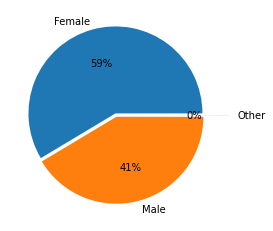

In [23]:
explode = [0.02,0.02,0.3]
plt.pie(gender_value_counts.array, labels=gender_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

#### Age

#### Hypertension

From all the persons in our dataset, we can see that only 10% have had hypertension.

In [27]:
hypertension_value_counts = stroke_df.hypertension.value_counts()
hypertension_value_counts

0    4612
1     498
Name: hypertension, dtype: int64

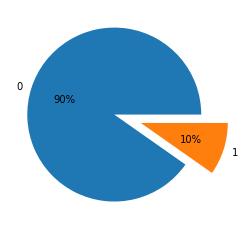

In [25]:
explode = [0.02,0.3]
plt.pie(hypertension_value_counts.array, labels=hypertension_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

#### Heart Disease

#### Marital Status

The values for marital status are 'Yes' or 'No' values. We prefer to have 0 or 1 values instead.

In [29]:
ever_married_value_counts = stroke_df.ever_married.value_counts()
ever_married_value_counts

Yes    3353
No     1757
Name: ever_married, dtype: int64

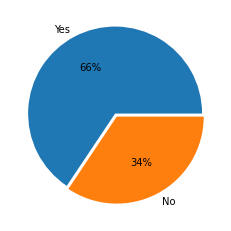

In [32]:
explode = [0.02,0.02]
plt.pie(ever_married_value_counts.array, labels=ever_married_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

#### Work Type

We have identified several work types i.e. private, self-employed, government job, children and never worked.

In [33]:
work_type_value_counts = stroke_df.work_type.value_counts()
work_type_value_counts

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

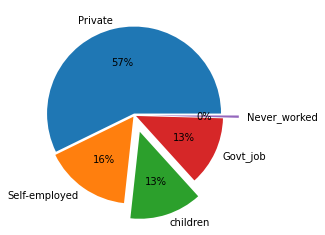

In [35]:
explode = [0.02,0.02,0.2,0.02,0.2]
plt.pie(work_type_value_counts.array, labels=work_type_value_counts.index, autopct = '%0.0f%%', explode = explode)
plt.show()

The values children and never worked might be corellated since most children don't work. Let's see how many never worked values are for people with an age greater than 18.

In [39]:
stroke_df.loc[(stroke_df['work_type'] == 'Never_worked') & (stroke_df['age'] > 18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0


Since we only have two values one approach would be to delete them, and convert the rest of the never worked values to children.

#### Residence Type

#### Average Glucoze Level

#### Body Mass Index

#### Smoking Status

### The label: Stroke

## Data Cleaning

###Gender

### Work Type

### Body Mass Index

### Smoking Status

## Random code

TODO: delete this section

In [ ]:
stroke_df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
stroke_df.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
stroke_df.age.map(lambda a: 1 if a >= 16 else 0).value_counts()

1    4366
0     744
Name: age, dtype: int64

In [ ]:
stroke_df[stroke_df["age"]<16][stroke_df["work_type"]!="children"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
410,54975,Male,7.0,0,0,No,Self-employed,Rural,64.06,18.9,Unknown,0
455,7351,Male,13.0,0,0,No,Private,Urban,92.14,23.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4709,41930,Male,15.0,0,0,No,Private,Rural,144.15,24.1,never smoked,0
4806,69723,Male,15.0,0,0,No,Private,Urban,137.27,19.3,never smoked,0
4903,56629,Female,14.0,0,0,No,Private,Rural,83.56,33.1,Unknown,0
4923,72186,Female,15.0,0,0,No,Private,Rural,82.19,40.5,never smoked,0
